In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.ndimage import binary_dilation
from sklearn.manifold import TSNE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
data = np.load('data/processed_data.npz')
X_test_flat = data['X_test_flat']
X_test_img = data['X_test_img']
y_test = data['y_test']

print("Data Loaded.")

Data Loaded.


In [ ]:
# Re-Define Model Classes

class DenseAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 128), nn.ReLU(), nn.Linear(128, latent_dim), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, 784), nn.Sigmoid())
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(), nn.Linear(32 * 7 * 7, latent_dim), nn.ReLU()
        )
        self.decoder_fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder_fc(encoded)
        decoded = self.decoder_conv(x)
        return decoded, encoded

BEST_DIM = 32
print("Loading models...")

dense_ae = torch.load(f'models/dense_ae_{BEST_DIM}.pth', map_location=device, weights_only=False)
conv_ae = torch.load(f'models/conv_ae_{BEST_DIM}.pth', map_location=device, weights_only=False)

dense_ae.eval()
conv_ae.eval()

print("PyTorch Models Loaded Successfully.")

Loading models...
PyTorch Models Loaded Successfully.


In [ ]:
# Dust Detection
def find_noisy_images(images):
    noisy_indices = []
    for i in range(len(images)):
        img = images[i].reshape(28, 28) * 255
        core_stroke = img > 50
        valid_zone = binary_dilation(core_stroke, iterations=2)
        dust = (img > 15) & (~valid_zone)
        if np.sum(dust) > 0:
            noisy_indices.append(i)
    return noisy_indices

noisy_idxs = find_noisy_images(X_test_flat)
print(f"Found {len(noisy_idxs)} dusty images.")

Found 72 dusty images.


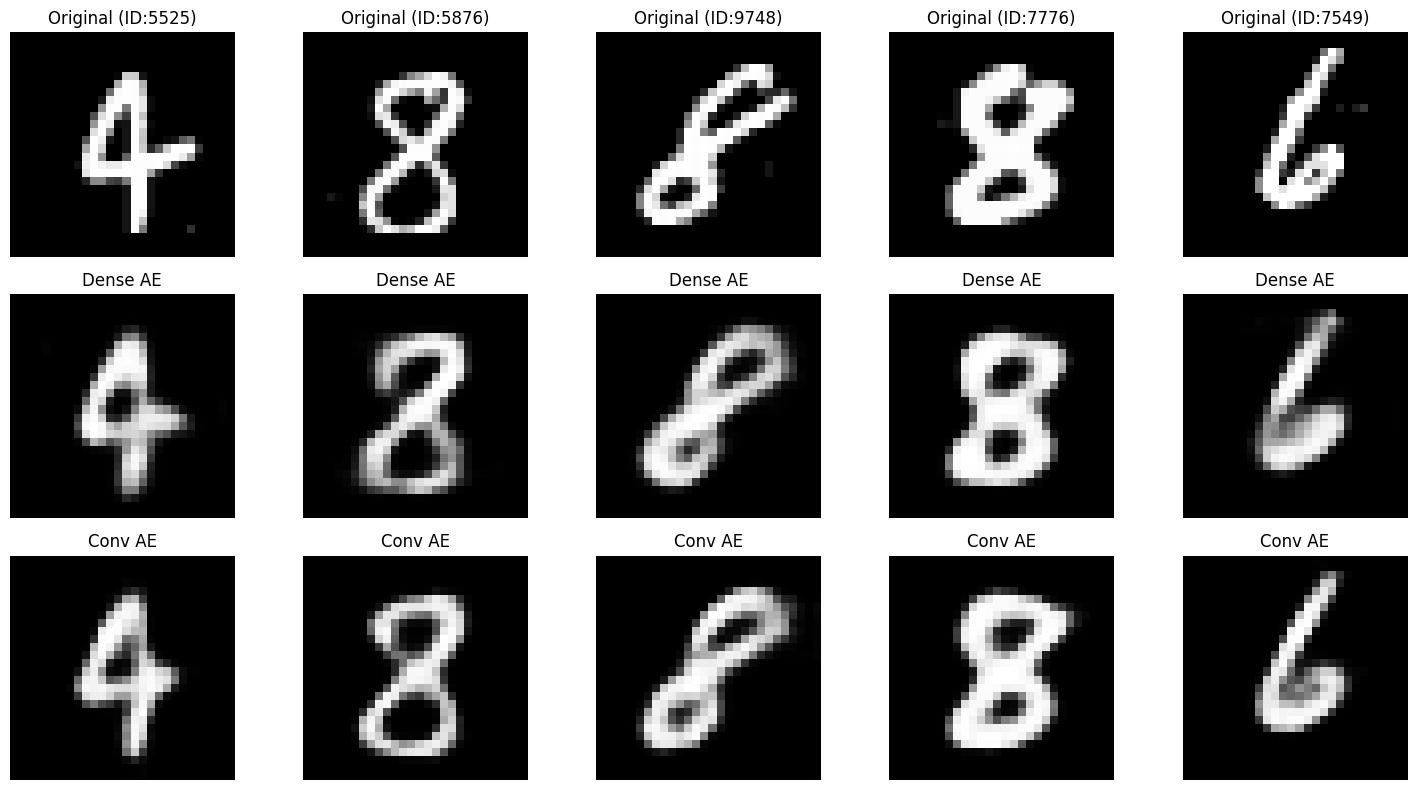

In [ ]:
# Reconstruction Visualization

num_to_show = 5
idxs_to_plot = np.random.choice(noisy_idxs, num_to_show, replace=False)

# Prepare inputs
input_dense = torch.Tensor(X_test_flat[idxs_to_plot]).to(device)
input_conv = torch.Tensor(X_test_img[idxs_to_plot]).to(device)

# Inference
with torch.no_grad():
    recon_dense, _ = dense_ae(input_dense)
    recon_conv, _ = conv_ae(input_conv)

recon_dense = recon_dense.cpu().numpy()
recon_conv = recon_conv.cpu().numpy()

plt.figure(figsize=(15, 8))
for i, idx in enumerate(idxs_to_plot):
    # Original
    plt.subplot(3, num_to_show, i + 1)
    plt.imshow(X_test_flat[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Original (ID:{idx})")
    plt.axis('off')
    
    # Dense
    plt.subplot(3, num_to_show, i + 1 + num_to_show)
    plt.imshow(recon_dense[i].reshape(28, 28), cmap='gray')
    plt.title("Dense AE")
    plt.axis('off')

    # Conv
    plt.subplot(3, num_to_show, i + 1 + 2*num_to_show)
    plt.imshow(recon_conv[i].reshape(28, 28), cmap='gray')
    plt.title("Conv AE")
    plt.axis('off')

plt.tight_layout()
plt.show()

Both autoencoders managed to reconstruct the images and remove noise from the test set.

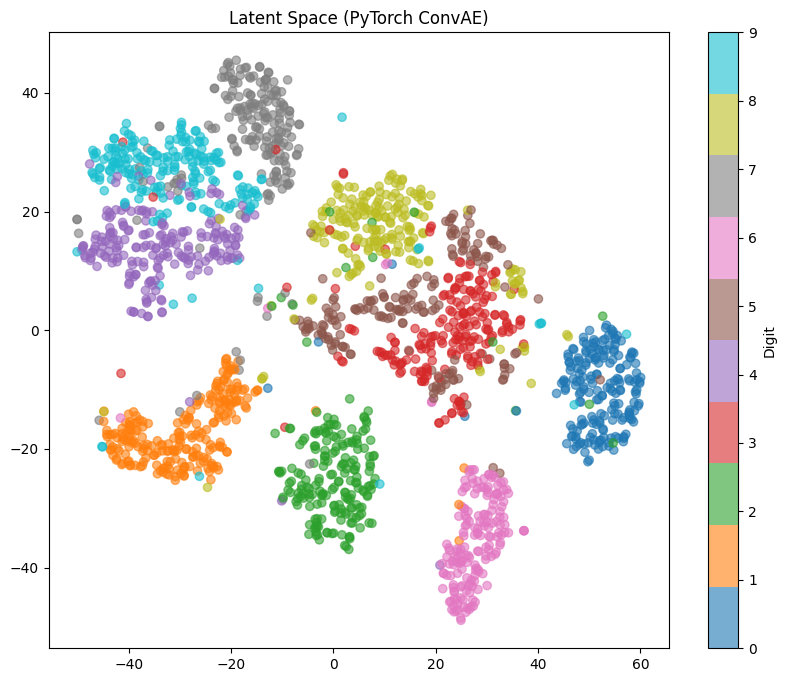

In [ ]:
# Latent Space (t-SNE)

subset_idx = np.random.choice(len(X_test_img), 2000, replace=False)
input_subset = torch.Tensor(X_test_img[subset_idx]).to(device)
y_subset = y_test[subset_idx]

with torch.no_grad():
    _, latent_vectors = conv_ae(input_subset)

latent_vectors = latent_vectors.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_subset, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit')
plt.title('Latent Space (PyTorch ConvAE)')
plt.show()